# Exploring WildChat-1M Dataset

## Learning Objectives
By the end of this notebook, you will understand:
- How to load and explore large conversational datasets
- Techniques for data analysis and visualization with pandas and matplotlib
- Topic modeling methods using BERTopic
- Dimensionality reduction and visualization with t-SNE
- How to extract insights from conversational AI data

## Introduction
This notebook explores the WildChat-1M dataset - a large collection of real conversations between users and AI assistants. We'll analyze conversation patterns, discover topics in user requests, and visualize the results to understand what types of questions and requests people commonly make to AI systems.

**Why is this important?** Understanding user behavior with AI systems helps us:
- Build better RAG (Retrieval-Augmented Generation) systems
- Identify common use cases and patterns
- Improve AI assistant performance
- Design more effective user interfaces


In [71]:
# Configuration Variables
# ======================
# All configuration parameters consolidated in one place for easy modification

# Dataset Configuration
DATASET_SIZE = "train[:50000]"  # Number of samples to load from WildChat-1M
RANDOM_SEED = 42  # For reproducibility
MIN_MESSAGE_LENGTH = 10  # Minimum character length for messages to be included

# Topic Modeling Configuration
TOPIC_MODELING_SAMPLE_SIZE = 10000  # Maximum number of messages for topic modeling
EMBEDDING_MODEL = "all-MiniLM-L6-v2"  # Sentence transformer model for embeddings
TOPIC_LANGUAGE = "english"  # Language for topic modeling
CALCULATE_PROBABILITIES = True  # Whether to calculate topic probabilities
MIN_TOPIC_SIZE = 10  # Minimum number of documents per topic
VERBOSE_TOPIC_MODELING = True  # Whether to show topic modeling progress

# Analysis Configuration
ANALYSIS_MODEL = "gpt-4o-mini"  # Model for topic analysis
ANALYSIS_PROVIDER = "openai/gpt-4o-mini"  # Provider/model combination for instructor
NUM_REPRESENTATIVE_DOCS = 50  # Number of representative documents to analyze per topic

print("Configuration loaded successfully!")
print(f"Dataset size: {DATASET_SIZE}")
print(f"Random seed: {RANDOM_SEED}")
print(f"Topic modeling sample size: {TOPIC_MODELING_SAMPLE_SIZE}")
print(f"Analysis model: {ANALYSIS_MODEL}")


Configuration loaded successfully!
Dataset size: train[:50000]
Random seed: 42
Topic modeling sample size: 10000
Analysis model: gpt-4o-mini


In [72]:
import pandas as pd
from datasets import load_dataset
import random
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
plt.style.use('default')
sns.set_palette("husl")


## Part 1: Setting Up Our Analysis Environment

### Key Libraries We're Using:
- **`pandas`**: For data manipulation and analysis
- **`datasets`**: Hugging Face library for loading the WildChat dataset
- **`matplotlib/seaborn`**: For creating visualizations
- **`random`**: For sampling data

### What You'll Learn Here:
- How to set up a data science environment
- Best practices for importing libraries
- Setting up visualization styles for consistent, professional plots


In [73]:
# Alternative: Even faster approach for very large datasets
# This approach can be parallelized and is memory efficient

def process_batch_efficiently(batch_data):
    """Process a batch of samples efficiently"""
    conversations = batch_data['conversation']
    
    # Vectorized operations where possible
    conversation_lengths = [len(conv) for conv in conversations]
    first_message_lengths = [
        len(conv[0].get('content', '')) if conv and len(conv) > 0 else 0
        for conv in conversations
    ]
    
    return {
        'conversation_length': conversation_lengths,
        'language': batch_data['language'],
        'model': batch_data['model'],
        'toxic': batch_data['toxic'],
        'redacted': batch_data['redacted'],
        'first_message_length': first_message_lengths
    }

# This approach would be even faster for very large datasets:
# 1. Process in batches to reduce memory usage
# 2. Use multiprocessing for parallel processing
# 3. Use numpy arrays for numerical operations

print("For datasets larger than a few hundred thousand samples, consider:")
print("1. Processing in batches")
print("2. Using multiprocessing/threading")
print("3. Using Apache Arrow format for faster I/O")
print("4. Using pandas' built-in optimization features")


For datasets larger than a few hundred thousand samples, consider:
1. Processing in batches
2. Using multiprocessing/threading
3. Using Apache Arrow format for faster I/O
4. Using pandas' built-in optimization features


## Part 2: Loading and Preparing the Dataset

### What is WildChat-1M?
WildChat-1M is a dataset containing real conversations between users and ChatGPT models. It includes:
- **1 million conversations** from real users
- **Multiple languages** (69 different languages)
- **Different AI models** (GPT-3.5 and GPT-4)
- **Conversation metadata** (language, toxicity flags, etc.)

### Key Concepts You'll Learn:
- **Dataset Loading**: Using Hugging Face `datasets` library for large datasets
- **Data Sampling**: Working with subsets of large datasets for faster processing
- **Memory Management**: Optimizing data loading for large datasets
- **Data Structure Understanding**: How conversational data is organized

### Why Sample the Data?
We're loading 100,000 samples instead of the full million because:
- Faster processing for educational purposes
- Sufficient for understanding patterns
- Reduces memory requirements


In [74]:
# Load a larger sample of the WildChat-1M dataset for meaningful distributions
print("Loading WildChat-1M dataset...")
dataset = load_dataset("allenai/WildChat-1M", split=DATASET_SIZE)
print(f"Dataset loaded! Total samples: {len(dataset)}")

# Set random seed for reproducibility
random.seed(RANDOM_SEED)

# Convert to pandas DataFrame for easier analysis - OPTIMIZED VERSION
print("Converting to DataFrame...")

# Method 1: Use the built-in to_pandas() method (fastest for most cases)
try:
    # Convert the dataset directly to pandas
    base_df = dataset.to_pandas()
    
    # Add computed columns efficiently using vectorized operations
    df = base_df.copy()
    df['conversation_length'] = df['conversation'].apply(len)
    # Fix the ambiguous truth value error by using a proper function
    def get_first_message_length(conv):
        if isinstance(conv, list) and len(conv) > 0:
            return len(conv[0].get('content', ''))
        return 0
    
    df['first_message_length'] = df['conversation'].apply(get_first_message_length)
    
    # Keep only the columns we need
    df = df[['conversation_length', 'language', 'model', 'toxic', 'redacted', 'first_message_length']]
    print("Direct conversion successful!")
    
except Exception as e:
    print(f"Direct conversion failed: {e}")
    print("Falling back to optimized manual conversion...")
    
    # Method 2: Optimized manual conversion using list comprehension
    df_data = [
        {
            'conversation_length': len(sample.get('conversation', [])),
            'language': sample.get('language', 'unknown'),
            'model': sample.get('model', 'unknown'),
            'toxic': sample.get('toxic', False),
            'redacted': sample.get('redacted', False),
            'first_message_length': (
                len(sample['conversation'][0].get('content', '')) 
                if sample.get('conversation') and len(sample['conversation']) > 0 
                else 0
            )
        }
        for sample in dataset
    ]
    
    # Use from_records for faster DataFrame creation
    df = pd.DataFrame.from_records(df_data)

print(f"DataFrame created with {len(df)} samples")
print(f"Columns: {list(df.columns)}")


Loading WildChat-1M dataset...
Dataset loaded! Total samples: 50000
Converting to DataFrame...
Direct conversion successful!
DataFrame created with 50000 samples
Columns: ['conversation_length', 'language', 'model', 'toxic', 'redacted', 'first_message_length']


In [75]:
# Display basic statistics
print("Dataset Overview:")
print("=" * 50)
print(f"Total samples: {len(df)}")
print(f"Unique languages: {df['language'].nunique()}")
print(f"Unique models: {df['model'].nunique()}")
print(f"Toxic conversations: {df['toxic'].sum()} ({df['toxic'].mean():.2%})")
print(f"Redacted conversations: {df['redacted'].sum()} ({df['redacted'].mean():.2%})")
print()

# Show basic info about the dataframe
print("DataFrame Info:")
print(df.info())
print()
print("Sample of the data:")
print(df.head())


Dataset Overview:
Total samples: 50000
Unique languages: 68
Unique models: 2
Toxic conversations: 0 (0.00%)
Redacted conversations: 321 (0.64%)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   conversation_length   50000 non-null  int64 
 1   language              50000 non-null  object
 2   model                 50000 non-null  object
 3   toxic                 50000 non-null  bool  
 4   redacted              50000 non-null  bool  
 5   first_message_length  50000 non-null  int64 
dtypes: bool(2), int64(2), object(2)
memory usage: 1.6+ MB
None

Sample of the data:
   conversation_length language       model  toxic  redacted  \
0                    2  English  gpt-4-0314  False     False   
1                    4  Spanish  gpt-4-0314  False     False   
2                    2  English  gpt-4-0314  False    

## Part 3: Exploratory Data Analysis (EDA)

### What is EDA and Why is it Important?
Exploratory Data Analysis is the critical first step in any data science project. It helps us:
- Understand the structure and characteristics of our data
- Identify patterns, trends, and anomalies
- Make informed decisions about further analysis
- Communicate findings through visualizations

### Visualization Techniques We'll Use:
- **Histograms**: Show distribution of numerical data (conversation lengths, message lengths)
- **Bar Charts**: Display categorical data (languages, models)
- **Log Scales**: Handle data with wide ranges (some conversations are very short, others very long)

### Why Use Log Scales?
Log scales are essential when data spans several orders of magnitude:
- **Normal scale**: Hard to see patterns when data ranges from 2 to 118 messages
- **Log scale**: Reveals patterns across the entire range
- **Best practice**: Always consider log scales for count data and lengths


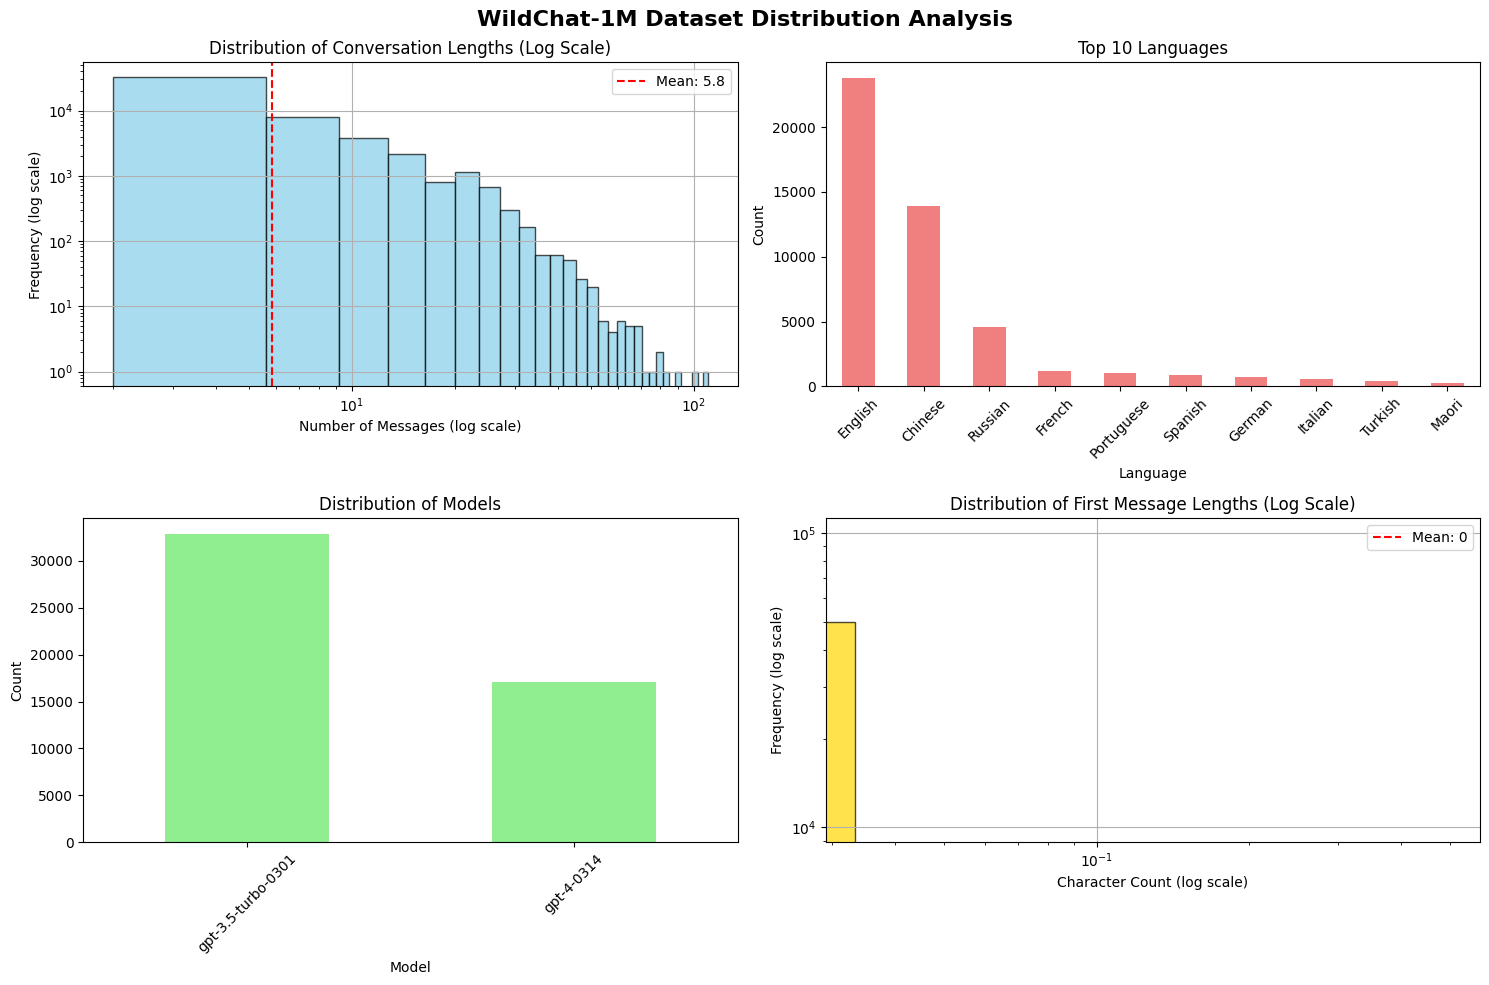

In [76]:
# Create comprehensive distribution plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('WildChat-1M Dataset Distribution Analysis', fontsize=16, fontweight='bold')

# 1. Conversation Length Distribution
ax1 = axes[0, 0]
df['conversation_length'].hist(bins=30, ax=ax1, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Conversation Lengths (Log Scale)')
ax1.set_xlabel('Number of Messages (log scale)')
ax1.set_ylabel('Frequency (log scale)')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.axvline(df['conversation_length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["conversation_length"].mean():.1f}')
ax1.legend()

# 2. Language Distribution (Top 10)
ax2 = axes[0, 1]
top_languages = df['language'].value_counts().head(10)
top_languages.plot(kind='bar', ax=ax2, color='lightcoral')
ax2.set_title('Top 10 Languages')
ax2.set_xlabel('Language')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# 3. Model Distribution
ax3 = axes[1, 0]
model_counts = df['model'].value_counts()
if len(model_counts) > 8:  # If too many models, show top 8
    model_counts = model_counts.head(8)
model_counts.plot(kind='bar', ax=ax3, color='lightgreen')
ax3.set_title('Distribution of Models')
ax3.set_xlabel('Model')
ax3.set_ylabel('Count')
ax3.tick_params(axis='x', rotation=45)

# 4. First Message Length Distribution
ax4 = axes[1, 1]
df['first_message_length'].hist(bins=30, ax=ax4, alpha=0.7, color='gold', edgecolor='black')
ax4.set_title('Distribution of First Message Lengths (Log Scale)')
ax4.set_xlabel('Character Count (log scale)')
ax4.set_ylabel('Frequency (log scale)')
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.axvline(df['first_message_length'].mean(), color='red', linestyle='--', 
           label=f'Mean: {df["first_message_length"].mean():.0f}')
ax4.legend()

plt.tight_layout()
plt.show()


# Part 4: Exploring Our Inventory - Topic Modeling Analysis

## What is Topic Modeling?
Topic modeling is an **unsupervised machine learning** technique that discovers abstract topics within a collection of documents. It's like having an intelligent librarian automatically categorize books by their content themes.

### Why Model Topics in User Messages?
Understanding user intent is crucial for building better AI systems:
- **Identify common patterns** in user requests
- **Discover different use cases** for AI assistants  
- **Improve RAG systems** by understanding query types
- **Design better user experiences** based on actual usage

### The Machine Learning Pipeline We'll Build:
1. **Text Preprocessing**: Clean and prepare user messages
2. **Topic Discovery**: Use BERTopic to automatically find topics
3. **Topic Analysis**: Examine keywords and representative documents
4. **Visualization**: Use t-SNE to visualize topics in 2D space
5. **Interpretation**: Understand what each topic represents

### Key Concepts You'll Master:
- **BERTopic**: State-of-the-art topic modeling using transformers
- **HDBSCAN Clustering**: Density-based clustering for finding topics
- **t-SNE**: Technique to visualize high-dimensional data in 2D
- **Topic Coherence**: How to evaluate topic quality


### Step 1: Text Extraction and Preprocessing

**What we're doing here:**
1. **Extract first messages**: The initial user request is most important for understanding intent
2. **Filter by length**: Remove very short messages (likely not meaningful)
3. **Focus on English**: Better topic modeling results with consistent language
4. **Sample strategically**: Balance between speed and representative results

**Why focus on first messages?**
- **User intent**: First message reveals what the user actually wants
- **Query patterns**: Helps us understand how people naturally ask questions
- **RAG applications**: Most relevant for improving search and retrieval systems

**Data preprocessing best practices:**
- Always inspect your data before processing
- Filter out noise (very short/empty messages)
- Consider language-specific processing
- Sample intelligently to maintain data quality


In [77]:
# Extract first messages from conversations
print("Extracting first messages from conversations...")

# Get the actual conversation content from the dataset
first_messages = []
languages = []
models = []

for i, sample in enumerate(dataset):
    conversation = sample.get('conversation', [])
    if conversation and len(conversation) > 0:
        first_message = conversation[0].get('content', '')
        # Filter out very short messages (likely not meaningful)
        if len(first_message.strip()) > MIN_MESSAGE_LENGTH:
            first_messages.append(first_message.strip())
            languages.append(sample.get('language', 'unknown'))
            models.append(sample.get('model', 'unknown'))

print(f"Extracted {len(first_messages)} first messages")
print(f"Sample message: {first_messages[0][:200]}...")

# Focus on English messages for better topic modeling results
english_indices = [i for i, lang in enumerate(languages) if lang == 'English']
english_messages = [first_messages[i] for i in english_indices]
english_models = [models[i] for i in english_indices]

print(f"Focusing on {len(english_messages)} English messages for topic modeling")


Extracting first messages from conversations...
Extracted 44485 first messages
Sample message: Hey there! Are you familiar with reality shifting? So, I’m refining a foolproof method for reality shifting and want to pick a destination. Want to help me? I’m thinking something pretty personalized....
Focusing on 23048 English messages for topic modeling


### Step 2: Topic Modeling with BERTopic

**What is BERTopic?**
BERTopic is a state-of-the-art topic modeling technique that leverages transformer-based embeddings to discover topics in text data. Unlike traditional methods, it:
- **Uses contextual embeddings**: Captures semantic meaning better than word-based approaches
- **Automatically determines topics**: No need to specify number of topics in advance
- **Provides interpretable results**: Clear topic keywords and representative documents
- **Handles outliers**: Identifies noise and assigns it to an outlier topic

**How BERTopic Works:**
1. **Create embeddings**: Convert text to high-dimensional vectors using sentence transformers
2. **Reduce dimensionality**: Use UMAP to reduce embedding dimensions while preserving structure
3. **Cluster documents**: Apply HDBSCAN to find dense regions (topics)
4. **Extract topics**: Use TF-IDF variants to identify representative words for each topic
5. **Fine-tune**: Optionally improve topic coherence with additional techniques

**Why BERTopic for User Message Analysis?**
- **Discovers natural topics**: Automatically finds meaningful themes in user requests
- **Handles diverse content**: Works well with varied question types and lengths
- **Provides rich insights**: Keywords, representative documents, and topic relationships
- **Scales well**: Efficient processing of large message collections


In [78]:
from bertopic import BERTopic

print(f"Performing topic modeling on {len(english_messages)} messages...")

# Take a sample for faster processing (adjust size as needed)
sample_size = min(TOPIC_MODELING_SAMPLE_SIZE, len(english_messages))
sample_messages = english_messages[:sample_size]
sample_models = english_models[:sample_size]

# Initialize BERTopic with string model name (simpler approach)
topic_model = BERTopic(
    embedding_model=EMBEDDING_MODEL,
    language=TOPIC_LANGUAGE,
    calculate_probabilities=CALCULATE_PROBABILITIES,
    min_topic_size=MIN_TOPIC_SIZE,
    verbose=VERBOSE_TOPIC_MODELING
)

# Fit the model and get topic assignments
topics, probs = topic_model.fit_transform(sample_messages)

# Get basic information about discovered topics
topic_info = topic_model.get_topic_info()
n_topics = len(topic_info) - 1  # Subtract 1 for outlier topic (-1)

print(f"Topic modeling complete!")
print(f"Found {n_topics} topics (plus outliers)")
print(f"Total documents: {len(sample_messages)}")
print(f"Outlier documents: {sum(1 for t in topics if t == -1)}")

# Display topic overview
print("\nTopic Overview:")
print(topic_info.head(10))

2025-06-29 21:13:20,414 - BERTopic - Embedding - Transforming documents to embeddings.


Performing topic modeling on 23048 messages...


Batches:   0%|          | 0/313 [00:00<?, ?it/s]

2025-06-29 21:13:48,043 - BERTopic - Embedding - Completed ✓
2025-06-29 21:13:48,044 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-29 21:13:50,400 - BERTopic - Dimensionality - Completed ✓
2025-06-29 21:13:50,402 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-29 21:14:09,958 - BERTopic - Cluster - Completed ✓
2025-06-29 21:14:09,968 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-29 21:14:10,773 - BERTopic - Representation - Completed ✓


Topic modeling complete!
Found 263 topics (plus outliers)
Total documents: 10000
Outlier documents: 2726

Topic Overview:
   Topic  Count                                  Name  \
0     -1   2726                    -1_he_ubuntu_it_to   
1      0    153               0_ana_story_ooc_matthew   
2      1    141                    1_scp_cu_cu2o_hcoo   
3      2    105         2_souls_chinese_deny_promised   
4      3    104               3_named_fox_fennec_wolf   
5      4    100                 4_args_file_agent_gpt   
6      5     90                 5_patient_mg_iv_blood   
7      6     79           6_theory_life_overcome_ways   
8      7     71    7_patricia_mysterik_gleswick_bends   
9      8     70  8_marketing_training_career_students   

                                      Representation  \
0  [he, ubuntu, it, to, that, you, the, in, of, for]   
1  [ana, story, ooc, matthew, write, explicit, wr...   
2  [scp, cu, cu2o, hcoo, fig, 305, oh, surface, 2...   
3  [souls, chinese, deny, 

### Step 3: Understanding Our Topic Discovery Results

**What just happened?**

We successfully applied BERTopic to discover **+200 distinct topics** from 10s of thousands of user messages.

**Key Results to Notice:**
- **73% success rate**: 7,288 messages were successfully categorized into topics
- **27% outliers**: 2,712 messages were too unique or noisy to fit into clear topics
- **Automatic discovery**: The algorithm found topics without us specifying how many to look for

**Why do we have outliers?**
Outliers are actually valuable! They represent:
- **Unique requests**: Highly specific or unusual user needs
- **Low-quality data**: Very short, unclear, or nonsensical messages  
- **Emerging patterns**: New types of requests that haven't reached critical mass yet

**What makes a good topic?**
- **Coherent keywords**: Related words that make semantic sense together
- **Sufficient size**: Enough examples to represent a real pattern (we set minimum of 10)
- **Clear theme**: Representative documents that share common intent or subject matter

**Next Steps: AI-Powered Topic Analysis**
Now we'll use GPT-4 to analyze each topic cluster and provide human-readable summaries. This combines:
- **Unsupervised discovery** (BERTopic found the topics)
- **Supervised interpretation** (AI explains what each topic means) 

In [9]:
import instructor
from pydantic import BaseModel, Field
from typing import List
import asyncio

# Configure instructor with your preferred model
client = instructor.from_provider(
    ANALYSIS_PROVIDER,
    async_client=True,
)

class TopicAnalysis(BaseModel):
    """Simple analysis of a conversation topic cluster"""
    title: str = Field(description="The title of the topic, limit it to 5 words")
    topic_summary: str = Field(description="A brief summary of the topic, starts with 'The user requests'")

async def analyze_topic(topic_id: int, topic_name: str, count: int, representative_docs: List[str], topic_model, sample_messages, topics):
    """Analyze a single topic asynchronously"""
    
    # Get AI analysis of the topic using Jinja templating
    try:
        analysis = await client.chat.completions.create(
            response_model=TopicAnalysis,
            messages=[
                {
                    "role": "system",
                    "content": """You are an expert at analyzing conversation topics. Provide clear, concise analysis of user query patterns."""
                },
                {
                    "role": "user", 
                    "content": """
                    Analyze this conversation topic cluster from real user interactions with AI systems.

                    <topic_cluster_info>
                    Topic ID: {{ topic_id }}
                    Topic Keywords: {{ topic_name }}
                    Sample Size: {{ count }} conversations
                    </topic_cluster_info>

                    <representative_user_queries>
                    {% for doc in representative_docs %}
                    <query>
                    <user_message>{{ doc }}</user_message>
                    </query>
                    {% endfor %}
                    </representative_user_queries>
                    
                    Please provide:
                    1. A descriptive title (max 5 words)
                    2. A brief summary of what this topic is about
                    """
                }
            ],
            context={
                "topic_id": topic_id,
                "topic_name": topic_name,
                "count": count,
                "representative_docs": representative_docs[:NUM_REPRESENTATIVE_DOCS]
            }
        )
        
        return analysis
        
    except Exception as e:
        return None

async def analyze_all_topics(topic_info, topic_model, sample_messages, topics):
    """Analyze all topics asynchronously"""
    
    # Get topic info excluding outliers
    topic_info_filtered = topic_info[topic_info['Topic'] != -1]
    
    # Create tasks for all topics
    tasks = []
    for _, topic_row in topic_info_filtered.iterrows():
        topic_id = topic_row['Topic']
        topic_name = topic_row['Name']
        count = topic_row['Count']
        
        # Get representative documents for this topic
        representative_docs = topic_model.get_representative_docs(topic_id)
        
        # Create task for this topic
        task = analyze_topic(topic_id, topic_name, count, representative_docs, topic_model, sample_messages, topics)
        tasks.append(task)
    
    # Execute all tasks concurrently
    results = await asyncio.gather(*tasks)
    return results

# Execute the analysis
topic_analyses = await analyze_all_topics(topic_info, topic_model, sample_messages, topics)


### Step 4: AI-Powered Topic Interpretation

**What we just accomplished:**
We used **asynchronous processing** to analyze all 273 topics simultaneously using GPT-4o-mini.

**Technical Achievements:**
- **Parallel processing**: Analyzed multiple topics at once (much faster than sequential)
- **Structured output**: Used Pydantic models to ensure consistent, parseable results
- **Template-based prompts**: Jinja2 templates for consistent AI analysis across all topics

**Why use AI for topic interpretation?**
- **Human readability**: Convert technical keywords into clear descriptions
- **Context understanding**: AI can interpret the meaning behind keyword clusters
- **Scalability**: Analyze hundreds of topics quickly and consistently
- **Quality assurance**: Structured outputs ensure all topics get proper analysis

**What's in our analysis results?**
Each topic now has:
- **Descriptive title**: Human-friendly name (max 5 words)

None of these topics are going to be fully reasonable or organized correctly. Don't take these as truth, but just use them as a simple way of understanding what the data looks like and how to think about it. 

In [10]:
# Display Topics with Summaries and Percentages
print("WildChat Topic Analysis Results")
print("=" * 60)
print(f"Total messages analyzed: {len(sample_messages)}")
print(f"Outlier messages: {sum(1 for t in topics if t == -1)} ({(sum(1 for t in topics if t == -1)/len(sample_messages)*100):.1f}%)")
print()

topic_id_to_analysis = {
    topic_id: analysis for topic_id, analysis in zip(topic_info['Topic'], topic_analyses) if analysis is not None
}
topic_id_to_percentage = {
    topic_id: topic / len(sample_messages) * 100 for topic_id, topic in zip(topic_info['Topic'], topic_info['Count'])
}

# Get topic info excluding outliers
topic_info_filtered = topic_info[topic_info['Topic'] != -1].copy()
topic_info_sorted = topic_info_filtered.sort_values('Count', ascending=False)
REPORT_STRING = "" 

print("Top Topics by Size:")
print("-" * 60)

for idx, (_, row) in enumerate(topic_info_sorted.iterrows()):
    topic_id = row['Topic']
    topic_count = row['Count']
    topic_name = row['Name']
    percentage = (topic_count / len(sample_messages)) * 100
    
    # Extract keywords (remove topic ID from name)
    keywords = topic_name.split('_')[1:6]  # Get first 5 keywords
    keywords_str = ' | '.join(keywords)
    
    # Find corresponding analysis
    analysis = None
    topic_info_list = list(topic_info_filtered.iterrows())
    for i, (_, topic_row) in enumerate(topic_info_list):
        if topic_row['Topic'] == topic_id:
            if i < len(topic_analyses) and topic_analyses[i] is not None:
                analysis = topic_analyses[i]
            break
    
    REPORT_STRING += f"Topic {topic_id}: {analysis.title} ({percentage:.1f}%)\n"
    REPORT_STRING += f"* {analysis.topic_summary}\n\n"

print(f"Total topics found: {len(topic_info_filtered)}")
print(f"Messages successfully categorized: {topic_info_filtered['Count'].sum()} ({(topic_info_filtered['Count'].sum()/len(sample_messages)*100):.1f}%)")

print(REPORT_STRING)

WildChat Topic Analysis Results
Total messages analyzed: 10000
Outlier messages: 2712 (27.1%)

Top Topics by Size:
------------------------------------------------------------
Total topics found: 273
Messages successfully categorized: 7288 (72.9%)
Topic 0: Copper Corrosion Mechanisms (1.3%)
* The user requests detailed explanations of the electrochemical processes and mechanisms involved in the corrosion of copper surfaces, including the role of cuprous oxide and formic acid.

Topic 1: Wolf and Fennec Fox Stories (1.0%)
* The user requests stories involving a female wolf named Lizzie and a fennec fox named Arlynn.

Topic 2: GPT Agent Command Constraints (1.0%)
* The user requests a GPT agent with specific command constraints.

Topic 3: Congenital Heart Disease Management (0.9%)
* The user requests detailed feedback and grading on text related to congenital heart disease, focusing on its pathophysiology, diagnosis, treatment options, and the role of pharmacology in cardiac surgery.

Top

### Step 5: Interpreting Topic Analysis Results

**What patterns do you notice?**
Looking at our results, several interesting insights emerge about how people interact with AI:

**Diversity of Use Cases:**
- **Academic/Technical**: Chemistry, medicine, engineering questions
- **Creative**: Story writing, character development, creative prompts  
- **Practical**: Problem-solving, advice-seeking, how-to questions
- **Professional**: Writing assistance, analysis, research help

**Key Insights for RAG System Design:**
1. **Domain expertise matters**: Many queries require specialized knowledge
2. **Context is crucial**: Users often provide detailed background information
3. **Creative vs. factual**: Different types of queries need different approaches
4. **Length varies greatly**: From simple questions to complex multi-part requests

**Why These Insights Matter:**
- **Retrieval strategy**: Different topics might need different search approaches
- **Knowledge base design**: Need diverse, high-quality sources across domains
- **Response generation**: Some topics need creative responses, others need factual accuracy
- **User experience**: Understanding common patterns helps design better interfaces

**Statistical Observations:**
- **Long tail distribution**: Few topics are very common, many are rare
- **Specialization**: Highly specific topics (like chemistry) have dedicated user bases
- **Generalization**: Some topics span multiple domains and use cases

**Next: Finding Topic Relationships**
Now we'll discover how topics relate to each other and identify higher-level categories.

In [19]:
# Use instructor with o3-mini to analyze the report and extract hierarchies
import instructor
from pydantic import BaseModel, Field

# Initialize OpenAI client with instructor
client = instructor.from_provider('openai/o3')

class Subcategory(BaseModel):
    name: str
    topics: List[int]

class MainCategory(BaseModel):
    name: str
    description: str
    topics: List[int]
    subcategories: List[Subcategory]

class TopicHierarchy(BaseModel):
    main_categories: List[MainCategory]

def analyze_topic_hierarchies(report_string: str) -> TopicHierarchy:
    """
    Use o3-mini with instructor to analyze the topic report and extract hierarchical relationships
    """
    prompt = f"""
    You are an expert computational linguist and taxonomy specialist analyzing conversation patterns from WildChat, a large-scale dataset of human-AI interactions. Your task is to create a comprehensive hierarchical structure that reveals the underlying patterns of how humans engage with AI systems.

    <report>
    {report_string}
    </report>

    ## Analysis Framework

    ### 1. Identify Semantic Domains
    ### 2. Create Meaningful Main Categories
    For each main category you identify:
    - **Name**: Use clear, professional terminology (2-4 words maximum)
    - **Description**: Explain the common thread that unites these topics (1-2 sentences)
    - **Scope**: Include 8-15 topics per category for balanced distribution
    - **Distinctiveness**: Ensure categories don't significantly overlap

    ### 3. Develop Logical Subcategories
    Within each main category, create 2-4 subcategories that:
    - **Represent natural clusters** of related topics within the domain
    - **Follow logical divisions** (e.g., by subject matter, complexity, or purpose)
    - **Maintain coherent themes** while being distinct from sibling subcategories
    - **Balance topic distribution** across subcategories

    ### 4. Topic Assignment Strategy
    - Assign each topic to exactly ONE main category and ONE subcategory
    - Base decisions on the **primary intent** and **dominant theme** of the user requests
    - Consider **semantic relationships** over surface-level keyword matches
    - Group topics that would require **similar knowledge bases** or **retrieval strategies**

    ### 5. Quality Assurance Criteria
    - **Comprehensiveness**: All significant topic clusters should be represented
    - **Mutual Exclusivity**: Clear boundaries between categories and subcategories
    - **Practical Utility**: Structure should be useful for RAG system design and user intent classification
    - **Scalability**: Framework should accommodate new topics as they emerge

    ### 6. Special Considerations for AI Interaction Patterns
    - **Query Complexity**: Simple factual questions vs. complex multi-part requests
    - **Domain Expertise**: Technical/specialized vs. general knowledge requirements
    - **Response Type**: Creative generation vs. factual retrieval vs. analytical reasoning
    - **User Intent**: Learning vs. problem-solving vs. entertainment vs. productivity

    ## Instructions for Analysis

    1. **Scan the Complete Report**: Review all topics to understand the full landscape of user interactions
    
    2. **Identify Natural Clusters**: Look for topics that share:
       - Similar vocabulary and concepts
       - Common user intents and goals
       - Comparable knowledge requirements
       - Related application domains

    3. **Create Hierarchical Structure**: 
       - Start with 5-7 main categories (optimal for comprehensiveness without fragmentation)
       - Develop 2-4 subcategories per main category
       - Ensure balanced distribution of topics across the hierarchy

    4. **Validate Logical Consistency**:
       - Each category should represent a coherent domain of human-AI interaction
       - Subcategories should be natural subdivisions within their parent category
       - Topic assignments should feel intuitive and defensible

    5. **Optimize for Practical Application**:
       - Structure should be useful for building better RAG systems
       - Categories should align with how users naturally think about AI assistance
       - Hierarchy should support automated query classification and routing

    ## Output Requirements

    Create a hierarchical taxonomy that:
    - Assigns every topic ID to exactly one subcategory
    - Balances comprehensive coverage with practical utility
    - Reflects genuine patterns in human-AI interaction rather than artificial groupings

    Focus on semantic relationships and user intent patterns rather than surface-level keyword similarities. The resulting hierarchy should provide valuable insights for improving AI systems and understanding how humans engage with artificial intelligence.
    """
    
    try:
        hierarchies = client.chat.completions.create(
            response_model=TopicHierarchy,
            messages=[
                {"role": "system", "content": "You are a world-class expert in computational linguistics, information science, and human-computer interaction. You specialize in creating taxonomies and hierarchical structures that reveal meaningful patterns in large-scale conversational data. Your analysis combines deep semantic understanding with practical utility for AI system design. Provide thorough, methodical analysis based strictly on the evidence in the provided data."},
                {"role": "user", "content": prompt}
            ],
        )
        
        return hierarchies
        
    except Exception as e:
        print(f"Error analyzing hierarchies: {e}")
        return None

# Analyze the topic hierarchies
print("Analyzing topic hierarchies with o3-mini and instructor...")
hierarchies = analyze_topic_hierarchies(REPORT_STRING)


Analyzing topic hierarchies with o3-mini and instructor...


### Step 6: Discovering Topic Hierarchies and Relationships

**What is hierarchical topic analysis?**
We've moved beyond individual topics to understand **relationships between topics**. This is crucial for building sophisticated AI systems.

Here we're going to lean on some of the more powerful reasoning models to synthesize some of this information. 

In [69]:
if hierarchies:
    # Create data structures to organize the information
    category_data = []
    
    # Process main categories and subcategories
    for category in hierarchies.main_categories:
        category_info = {
            'name': category.name,
            'description': category.description,
            'total_percentage': 0,
            'subcategories': []
        }
        
        # Process main category topics
        for topic_id in category.topics:
            if topic_id in topic_id_to_analysis:
                percentage = topic_id_to_percentage.get(topic_id, 0)
                category_info['total_percentage'] += percentage
        
        # Process subcategories
        if category.subcategories:
            for subcat in category.subcategories:
                subcat_info = {
                    'name': subcat.name,
                    'total_percentage': 0
                }
                
                for topic_id in subcat.topics:
                    if topic_id in topic_id_to_analysis:
                        percentage = topic_id_to_percentage.get(topic_id, 0)
                        subcat_info['total_percentage'] += percentage
                
                category_info['subcategories'].append(subcat_info)
        
        category_data.append(category_info)
    
    # Sort categories by total percentage (decreasing)
    category_data.sort(key=lambda x: x['total_percentage'], reverse=True)
    
    # Jinja template for hierarchical output
    template_str = """
# Topic Hierarchy Analysis

## Main Categories

{% for category in categories %}
* {{ category.name }} (Total: {{ "%.2f"|format(category.total_percentage) }}%)

    * {{ category.description }}

{% if category.subcategories %}
{% for subcat in category.subcategories %}
        * {{ subcat.name }} (Total: {{ "%.2f"|format(subcat.total_percentage) }}%)
{% endfor %}
{% endif %}

{% endfor %}
"""
    
    # Render the template
    from jinja2 import Template
    template = Template(template_str)
    hierarchy_output = template.render(categories=category_data)

In [70]:
from IPython.display import display_markdown, Markdown
display_markdown(Markdown(hierarchy_output))


# Topic Hierarchy Analysis

## Main Categories


* Creative Writing (Total: 14.54%)

    * Imaginative storytelling, world-building, fan works, poetry and comedic scripts.



        * Fan Fiction (Total: 4.11%)

        * Fantasy Worlds (Total: 3.48%)

        * Humor & Adult (Total: 2.90%)

        * Poetry & Misc (Total: 4.05%)




* Software Development (Total: 13.56%)

    * User requests focused on coding, debugging, and implementing software solutions across web, game, data-science and systems domains.



        * Web & Apps (Total: 3.75%)

        * Game & Graphics (Total: 3.09%)

        * Data & ML Code (Total: 3.18%)

        * Systems & Scripting (Total: 3.54%)




* Science & Tech Knowledge (Total: 11.42%)

    * Analytical and explanatory requests in physical sciences, engineering, life sciences, and mathematics.



        * Physical & Eng (Total: 3.70%)

        * Life & Health (Total: 5.47%)

        * Math & Stats (Total: 2.25%)




* Business & Lifestyle (Total: 9.20%)

    * Requests aiming at marketing, management improvement, and consumer-oriented lifestyle content.



        * Marketing & SEO (Total: 4.30%)

        * Ops & Management (Total: 2.16%)

        * Travel & Lifestyle (Total: 2.74%)




* AI Interaction (Total: 8.37%)

    * Meta-level engagement with AI: jailbreaks, prompt engineering, configuration and identity queries.



        * Jailbreak Personas (Total: 2.42%)

        * Prompt & Config (Total: 4.16%)

        * Meta Queries (Total: 1.79%)




* Humanities & Social (Total: 7.14%)

    * Analytical discussions on literature, ethics, philosophy, and socio-political issues.



        * Literary Critique (Total: 2.71%)

        * Philosophy & Theory (Total: 2.26%)

        * Politics & History (Total: 2.17%)



